In [25]:
# Import the python libraries
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

#### 가상 포트폴리오 만들기

In [3]:
# Amazon, Apple, Netflix, Alphabet 데이터 불러오기
assets =  ["AMZN", "AAPL", "NFLX", "GOOG"]

In [4]:
# 포트폴리오 구성 (종목별 동일한 가중치로 설정)
weights = np.array([0.25, 0.25, 0.25, 0.25])
weights

array([0.25, 0.25, 0.25, 0.25])

In [5]:
# 시작일은 2013-01-01 종료일은 현재 2023-12-31
stockStartDate = '2013-01-01'
stockEndDate = '2023-01-01'

In [6]:
# 각 주식의 일별 종가 데이터를 저장할 데이터프레임 생성
def fetch_data(assets: list, start_dt: str, end_dt: str) -> pd.DataFrame:
    closes = []
    for ticker in assets:
        fetched_df = fdr.DataReader(ticker, start = start_dt, end = end_dt)
        history_df = pd.DataFrame({'Date':fetched_df.index, ticker:fetched_df['Close']})
        history_df.set_index('Date', drop=True, inplace=True)
        closes.append(history_df)

    closes = pd.concat(closes, axis=1)
    closes.dropna(inplace=True)
    return closes
    

# Store the adjusted close price of stock into the data frame
df = fetch_data(assets = assets, start_dt = stockStartDate, end_dt = stockEndDate)

In [7]:
df.head()

,AMZN,AAPL,NFLX,GOOG
Date,,,,
2013-01-02,12.8655,19.608213,13.144286,18.013729
2013-01-03,12.9240,19.360714,13.798571,18.024191
2013-01-04,12.9575,18.821428,13.711429,18.380356
2013-01-07,13.4230,18.710714,14.171429,18.300158
2013-01-08,13.3190,18.761070,13.880000,18.264042


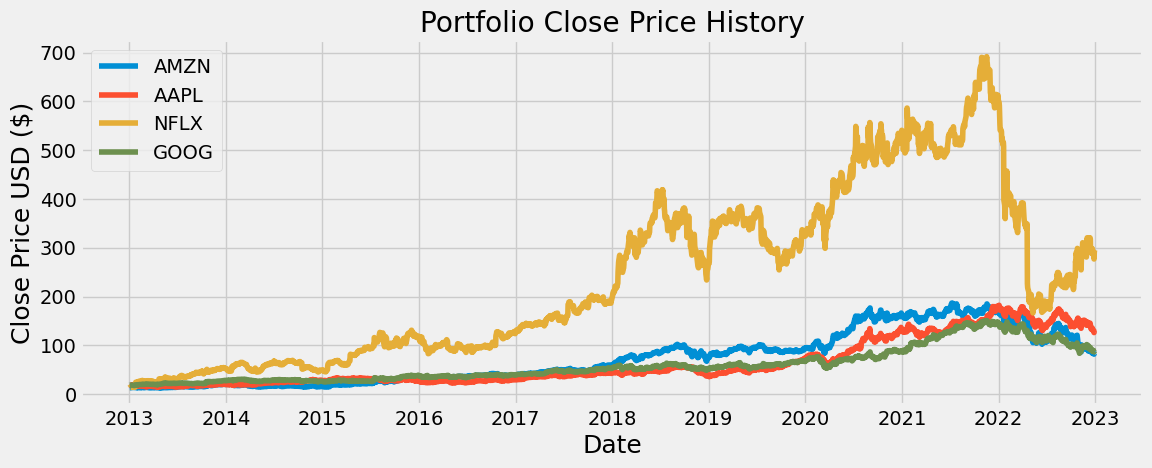

In [8]:
# 포트폴리오 일별 종가 그래프 시각화

# Create and plot the graph
plt.figure(figsize=(12.2,4.5)) # width = 12.2in, height = 4.5

# Loop through each stock and plot the Adj Close for each day
for c in df.columns.values:
  plt.plot( df[c],  label=c) #plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)
plt.title('Portfolio Close Price History')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.legend(df.columns.values, loc='upper left')
plt.show()

In [9]:
# 일일 단순 수익률 구하기
returns = df.pct_change()
returns

,AMZN,AAPL,NFLX,GOOG
Date,,,,
2013-01-02,NaN,NaN,NaN,NaN
2013-01-03,0.004547,-0.012622,0.049777,0.000581
2013-01-04,0.002592,-0.027855,-0.006315,0.019760
2013-01-07,0.035925,-0.005882,0.033549,-0.004363
2013-01-08,-0.007748,0.002691,-0.020565,-0.001974
...,...,...,...,...
2022-12-23,0.017425,-0.002798,-0.009370,0.017562
2022-12-27,-0.025924,-0.013878,-0.036581,-0.020933
2022-12-28,-0.014692,-0.030685,-0.025654,-0.016718


In [10]:
# 연간 공분산 행렬을 통해 자산 가격간의 방향 관계 파악
cov_matrix_annual = returns.cov() * 252 # 연간 거래일수는 252일로 설정
cov_matrix_annual

,AMZN,AAPL,NFLX,GOOG
AMZN,0.106347,0.048020,0.074730,0.055710
AAPL,0.048020,0.084545,0.043882,0.045082
NFLX,0.074730,0.043882,0.228087,0.056313
GOOG,0.055710,0.045082,0.056313,0.073510


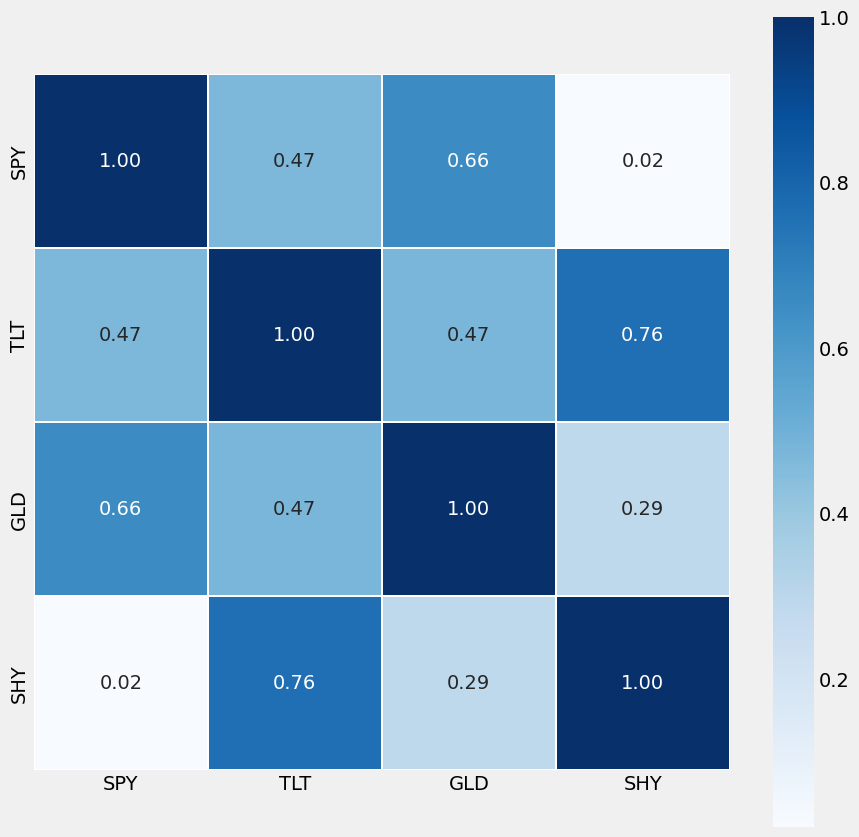

In [26]:
# 상관계수 히트맵 플로팅
corrmat = returns.corr()
plt.figure(figsize=(10,10))
cm = np.corrcoef(df.values.T)
hm = sns.heatmap(cm, cmap='Blues', cbar=True, annot=True, square=True, fmt='.2f',
                 linewidths=0.01, xticklabels=df.columns, yticklabels=df.columns)
plt.show()

In [11]:
# 포트폴리오 분산 계산
pf_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
pf_variance

0.07124766108003808

In [12]:
# 포트폴리오 변동성 계산
pf_std = np.sqrt(pf_variance)
pf_std

0.26692257506632533

In [13]:
# 포트폴리오 연간 단순 수익률 계산
pf_year_return = np.sum(returns.mean()*weights) * 252
pf_year_return

0.27344016353756395

In [14]:
# 예상 연간 수익, 변동성 또는 위험 및 분산
percent_var = str(round(pf_variance, 2) * 100) + '%'
percent_vols = str(round(pf_std, 2) * 100) + '%'
percent_ret = str(round(pf_year_return, 2)*100)+'%'
print(f'예상 연간 수익 : {percent_ret}')
print(f'연간 변동성/위험 : {percent_vols}')
print(f'연간 분산 : {percent_var}')

예상 연간 수익 : 27.0%
연간 변동성/위험 : 27.0%
연간 분산 : 7.000000000000001%


In [15]:
# 동일한 비중으로 포트폴리오를 구성한 경우, 연간 예상 투자 수익률이 27%
# 포트폴리오 위험이 23%

#### EfficientFrontier() 
- pypfopt 라이브러리에서 제공되는 클래스로 포트폴리오 최적화를 수행하기 위한 다양한 메서드와 속성을 포함
- 이 클래스는 각종 최적화 기술을 사용하여 효율적인 포트폴리오를 찾을 수 있음

#### EfficientFrontier(expected_returns, cov_matrix)
- expected_returns: 기대수익률을 나타내는 시리즈 또는 딕셔너리로 종목별 기대 수익률 포함해야 함
- cov_matrix: 공분산 행렬을 나타내는 데이터프레임으로 종목 간의 공분산 정보를 포함해야 함
- max_sharpe_ratio()는: 최대 샤프 비율을 가지는 포트폴리오의 비중을 찾음, 반환값은 최적화된 포트폴리오의 종목별 비중
- min_volatility(): 최소 변동성을 가지는 포트폴리오의 비중을 찾음, 반환값은 최적화된 포트폴리오의 종목별 비중
- efficient_risk(target_risk): 주어진 목표 리스크에 도달하는 효율적인 포트폴리오의 비중을 찾음, 반환값 동일, target_risk는 목표 리스크 값.
- efficient_return(target_return): 주어진 목표 수익률에 도달하는 효율적인 포트폴리오의 비중을 찾음, target_return는 목표 수익률 값
- plot_efficient_frontier(): 효율적인 포트폴리오의 전체 곡선을 시각화

In [16]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [17]:
# 예상 수익률과 일일 자산 수익률의 연간 표본 공분산 행렬 계산
mu = expected_returns.mean_historical_return(df) #returns.mean() * 252
S = risk_models.sample_cov(df) #Get the sample covariance matrix

In [18]:
mu

AMZN    0.206653
AAPL    0.208440
NFLX    0.365375
GOOG    0.173084
dtype: float64

In [19]:
S

,AMZN,AAPL,NFLX,GOOG
AMZN,0.106347,0.048020,0.074730,0.055710
AAPL,0.048020,0.084545,0.043882,0.045082
NFLX,0.074730,0.043882,0.228087,0.056313
GOOG,0.055710,0.045082,0.056313,0.073510


In [20]:
# 최대 Sharpe Ratio 최적화
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe() #Maximize the Sharpe ratio, and get the raw weights
cleaned_weights = ef.clean_weights() 
print(cleaned_weights) #Note the weights may have some rounding error, meaning they may not add up exactly to 1 but should be close
ef.portfolio_performance(verbose=True)

OrderedDict([('AMZN', 0.07941), ('AAPL', 0.48145), ('NFLX', 0.37986), ('GOOG', 0.05928)])
Expected annual return: 26.6%
Annual volatility: 28.9%
Sharpe Ratio: 0.85


(0.2658161130976634, 0.2886220653106105, 0.8516885666143369)

In [22]:
# Amzon은 7.941%, Apple은 48.14%, Netflix는 37.98%, Google은 5.928%
# 해당 비중을 보유함으로써 이 포트폴리오를 최적화할 수 있음

# 최적화를 통해 예상 연간 수익이 26.6%로 증가했으며
# 연간 변동성/위험이 28.86%임을 알 수 있음
# 최적화된 포트폴리오는 0.85%의 Sharpe 비율을 가짐

In [ ]:
# pypfopt 라이브러리를 사용하여 포트폴리오 최적화하는 예시
# 포트폴리오 최적화를 위해서는 해당 ETF들에 대한 예상 수익률과 공분산 구해야 함

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# ETF에 대한 예상 수익률 및 리스크 모델 데이터 (실제 데이터로 대체해야 함)
expected_returns_data = {"SPY": 0.08, "AGG": 0.02}
cov_matrix_data = {"SPY": {"SPY": 0.0004, "AGG": 0.0001},
                   "AGG": {"SPY": 0.0001, "AGG": 0.0002}}

# EfficientFrontier 객체 생성
ef = EfficientFrontier(expected_returns_data, cov_matrix_data)

# 최대 샤프 비율을 가지는 포트폴리오 비중 계산
weights = ef.max_sharpe_ratio()

# 최적화된 포트폴리오 결과 출력
weights